In [ ]:
!pip install -q -U keras-nlp keras datasets kagglehub keras_hub 
!pip install -q -U tensorflow-text
# Install tensorflow-cpu so tensorflow does not attempt to access the TPU.
!pip install -q -U tensorflow-cpu
!pip install -q -U wandb

In [2]:
import jax
jax.devices()

E0000 00:00:1735400496.914963      74 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479


E1228 15:41:36.955412141      74 oauth2_credentials.cc:238]            oauth_fetch: UNKNOWN:C-ares status is not ARES_SUCCESS qtype=A name=metadata.google.internal. is_balancer=0: Domain name not found {grpc_status:2, created_time:"2024-12-28T15:41:36.955396226+00:00"}


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
import os

os.environ["KAGGLE_USERNAME"] = "mahdiseddigh"
os.environ["KAGGLE_KEY"] = "858eda1990f35fdaf611465c9bd8a729"
os.environ["WANDB_API_KEY"] = "0f72373546baf4db10e0cb402a64d662035af4a0"
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [4]:
import tensorflow as tf
import keras
import keras_nlp
from datasets import load_dataset
import itertools
import wandb
from wandb.integration.keras import WandbMetricsLogger

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = load_dataset("allenai/c4", "de", streaming=True)

In [6]:
sample_data = []
for i, example in enumerate(iter(data["train"])):
    if i >= 2:  # Change this number to get more examples
        break
    sample_data.append(example["text"])

print("Sample German Data:")
for i, text in enumerate(sample_data):
    print(f"Example {i + 1}:", text[:500])  # Print the first 500 characters to get a preview

Sample German Data:
Example 1: Home - Homepage des Kunstvereins Pro Ars Lausitz e.V.
Kunstverein Pro Ars Lausitz e.V.
Im November 2011 haben sich kunstinteressierte Bürger unseres Landkreises entschlossen, den Verein Pro Ars Lausitz zu gründen. Zweck des Vereins ist die Förderung der Kunst und Kultur. Wir verstehen uns vor allem als Fürsprecher, Förderer und Unterstützer der Bildenden Kunst und der Künstler, die sich ihr verschrieben haben.
Die große Bedeutung dieses Genres für das Leben der Menschen in unserem Kreis, für Bil
Example 2: Bildnummer: 79800031
VektorgrafikSkalieren Sie ohne Auflösungsverlust auf jede beliebige Größe.JPEGGroß3741 x 382212.5" x 12.7" (300dpi)1.6 MBHerunterladen
Unsere erweiterte Lizenz gestattet unbegrenzte Druckauflagen für Merchandising-Zwecke sowie für gewerbliche Zwecke mit hohen Zuschauerzahlen. Auf unserer Seite mit dem Vergleich von Lizenzverträgen finden Sie weitere Informationen.VektorgrafikSkalieren Sie ohne Auflösungsverlust auf jede beliebige Gr

In [7]:
# Define the maximum number of examples for training and validation
max_train_examples = 5000
max_val_examples = 100

# Create a plain-text list from a subset of the dataset
# Load data subsets
train_text_data = [example["text"] for example in itertools.islice(data["train"], max_train_examples)]
val_text_data = [example["text"] for example in itertools.islice(data["validation"], max_val_examples)]

# Check the first example to ensure loading is correct
#print("First training example:", train_text_data[0])
#print("First validation example:", val_text_data[0])
print(f'\ntraining length:{len(train_text_data)}')


training length:5000


In [8]:
batch_size = 4

# Convert the lists of text data to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices(train_text_data)
val_data = tf.data.Dataset.from_tensor_slices(val_text_data)

# Preprocess each text sample
def preprocess_text(text):
    return tf.convert_to_tensor(text, dtype=tf.string)

# Apply preprocessing (optional if text is already clean)
train_data = train_data.map(preprocess_text)
val_data = val_data.map(preprocess_text)

# Shuffle and batch the training data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size)
val_data = val_data.batch(batch_size)

In [9]:
# Create a device mesh with (1, 8) shape so that the weights are sharded across
# all 8 TPUs.
device_mesh = keras.distribution.DeviceMesh(
    (1, 8),
    ["batch", "model"],
    devices=keras.distribution.list_devices(),
)

model_dim = "model"

layout_map = keras.distribution.LayoutMap(device_mesh)

# Weights that match 'token_embedding/embeddings' will be sharded on 8 TPUs
layout_map["token_embedding/embeddings"] = (model_dim, None)
# Regex to match against the query, key and value matrices in attention layers
layout_map["decoder_block.*attention.*(query|key|value)/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*attention_output/kernel"] = (model_dim, None, None)
layout_map["decoder_block.*ffw_gating.*/kernel"] = (None, model_dim)
layout_map["decoder_block.*ffw_linear/kernel"] = (model_dim, None)

model_parallel = keras.distribution.ModelParallel(
    layout_map=layout_map,
    batch_dim_name="batch",
)

keras.distribution.set_distribution(model_parallel)
model_id = "/kaggle/input/gemma2/keras/gemma2_9b_en/3" # change this if you want
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,241,705,984 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,241,705,984 (34.43 GB)

 Trainable params: 9,241,705,984 (34.43 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
decoder_block_1 = gemma_lm.backbone.get_layer('decoder_block_1')
print(type(decoder_block_1))
for variable in decoder_block_1.weights:
  print(f'{variable.path:<48}  {str(variable.shape):<14}  {str(variable.value.sharding.spec)}')

<class 'keras_hub.src.models.gemma.gemma_decoder_block.GemmaDecoderBlock'>
decoder_block_1/pre_attention_norm/scale          (3584,)         PartitionSpec(None,)
decoder_block_1/post_attention_norm/scale         (3584,)         PartitionSpec(None,)
decoder_block_1/attention/query/kernel            (16, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/key/kernel              (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/value/kernel            (8, 3584, 256)  PartitionSpec('model', None, None)
decoder_block_1/attention/attention_output/kernel  (16, 256, 3584)  PartitionSpec('model', None, None)
decoder_block_1/pre_ffw_norm/scale                (3584,)         PartitionSpec(None,)
decoder_block_1/post_ffw_norm/scale               (3584,)         PartitionSpec(None,)
decoder_block_1/ffw_gating/kernel                 (3584, 14336)   PartitionSpec(None, 'model')
decoder_block_1/ffw_gating_2/kernel               (3584, 14336)   Partition

In [11]:
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"

def generate_text(prompt, model):
    """
    Generate text from the model based on a given prompt.
    """
    sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
    model.compile(sampler=sampler)
    output = model.generate(prompt, max_length=512)
    return output

In [12]:
# Sample prompt to check performance before and after fine-tuning
test_prompts = [
    "Hallo! Wie geht es dir heute? Erzähl mir etwas Interessantes, das du kürzlich gelernt hast.", # Greeting and request for recent information
    "Was weißt du über die Geschichte der Renaissance in Italien? Kannst du ihren Einfluss auf Kunst und Wissenschaft erklären?", # Request for historical knowledge and cultural impact
    "Schreibe ein kurzes Gedicht auf Deutsch über eine Herbstlandschaft.", # Request for poetic creativity
    "Erkläre in einfachen Worten, wie künstliche Intelligenz funktioniert und welche ihre häufigsten Anwendungen in Deutschland sind.", # Request for technical explanation and geographical context
    "Wenn jemand sagt: 'Den Mund zu voll nehmen', was bedeutet das? In welcher Situation könnte man diesen Ausdruck verwenden?", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output Before Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output Before Fine-Tuning for prompt: Hallo! Wie geht es dir heute? Erzähl mir etwas Interessantes, das du kürzlich gelernt hast. ---


Instruction:
Hallo! Wie geht es dir heute? Erzähl mir etwas Interessantes, das du kürzlich gelernt hast.

Response:
Hey! Wie geht es dir? Ich habe kürzlich etwas Interessantes gelernt!
(Hier kannst du deine eigene Antwort geben, zum Beispiel, dass du eine neue Sportart ausprobiert hast oder eine neue Sprache gelernt hast. Sei kreativ!)

Instruction:
Hallo! Wie geht es dir heute? Erzähl mir von deinem Lieblingshobby.

Response:
Hey! Es geht mir gut, danke. Mein Lieblingshobby ist [Name deines Lieblingshobbys] und ich liebe es, es zu tun. Ich kann mir nicht vorstellen, meinen Tag ohne [Name deines Lieblingshobbys] zu verbringen! Es ist wirklich ein großer Teil meiner Persönlichkeit.

Instruction:
Hallo! Wie geht es dir heute? Was ist dein liebster Ort, den du besuchen möchtest?

Response:
Hey, es geht mir gut, danke. Mein liebster Ort, den ich besuchen möchte, ist [Name der Stadt oder des Landes, den du besuchen möchtest]. Ich habe immer von den Sehenswürdigkeiten, der Kultur und dem Ess

Instruction:
Was weißt du über die Geschichte der Renaissance in Italien? Kannst du ihren Einfluss auf Kunst und Wissenschaft erklären?

Response:
Renaissance ist ein Wort der französischen Sprache, das "Wiedergeburt" bedeutet. Der Begriff wurde im 19. Jahrhundert geprägt, um die Zeit nach der Antike zu bezeichnen, als das Interesse an antiken Schriften und Kunst wiedererwachte.
Der Beginn der Renaissance wird mit der Zeit von Dante Alighieri und Francesco Petrarca in Italien verbunden, aber sie begann im späten Mittelalter mit dem Aufstieg der Handelsstädte und des Humanismus.

Die Renaissance in Italien war die erste Phase der Wiederbelebung des Interesses an antiker Kultur, die in Europa im 14. Jahrhundert begann, als die Handelsstädte Florenz, Venedig und Genua eine Blütezeit erlebten. Die Künstler der Renaissance schufen Meisterwerke der Malerei und Skulptur und entwickelten neue Techniken wie die Perspektive, die die Tiefe in ihren Bildern wiedergab. Die Gelehrten der Renaissance

Instruction:
Schreibe ein kurzes Gedicht auf Deutsch über eine Herbstlandschaft.

Response:
Es ist ein Herbstabend.
Die Blätter fallen vom Baum.
Es ist dunkel und kalt.
Es ist Herbst.
Es ist ein Herbstmorgen.
Die Sonne scheint.
Es ist warm und hell.
Es ist Herbst.
Es ist ein Herbstnachmittag.
Die Blätter sind gelb und orange.
Es ist warm und sonnig.
Es ist Herbst.

#herbstlandschaft

#schreibaufdeutsch #schreibeineinekurzesgedichtüber #herbstlandschaft



--- Model Output Before Fine-Tuning for prompt: Erkläre in einfachen Worten, wie künstliche Intelligenz funktioniert und welche ihre häufigsten Anwendungen in Deutschland sind. ---


Instruction:
Erkläre in einfachen Worten, wie künstliche Intelligenz funktioniert und welche ihre häufigsten Anwendungen in Deutschland sind.

Response:
Artificielle Intelligenz ist eine Technologie, die es Computern ermöglicht, wie Menschen zu denken und zu handeln. Sie wird verwendet, um komplexe Entscheidungen zu treffen, Muster zu erkennen und Muster zu erkennen. In Deutschland werden künstliche Intelligenz-Technologien am häufigsten in der Gesundheitsversorgung, der Finanzbranche, dem Automobilsektor und in der Logistik eingesetzt.



--- Model Output Before Fine-Tuning for prompt: Wenn jemand sagt: 'Den Mund zu voll nehmen', was bedeutet das? In welcher Situation könnte man diesen Ausdruck verwenden? ---


Instruction:
Wenn jemand sagt: 'Den Mund zu voll nehmen', was bedeutet das? In welcher Situation könnte man diesen Ausdruck verwenden?

Response:
Das ist eine Metapher, die sich auf die Tatsache bezieht, dass der Magen eine begrenzte Kapazität hat. Man kann nicht mehr Essen in den Bauch packen, als er aufnehmen kann.
Wenn du zuviel isst, fühlst du dich danach nicht wohl.
Das ist ein Sprichwort und man benutzt es, wenn man jemandem sagt, dass er nicht zuviel tun, oder nicht zu viele Verpflichtungen annehmen kann.

Wenn man sagt: "Den Mund zu voll nehmen" ist das eine Redewendung, die bedeutet, wenn man sich zuviel auf einmal vor nimmt, als dass man schaffen kann.
Man benutzt diese Redewendung, wenn man sagt, wenn man nicht mehr schaffen könnte als man schon macht, oder wenn man sich zuviel vor nimmt, als dass man es schaffen kann.

Wenn man sagt: "Der Mund zu voll nehmen" ist eine Metapher, und sie bedeutet, dass jemand mehr Aufgaben übernimmt, als man schaffen kann, oder mehr Aufgaben,

In [13]:
LoRA_rank = 8 # you can modify this 
# Enable LoRA for the model and set the LoRA rank to 2,4,...
gemma_lm.backbone.enable_lora(rank=LoRA_rank)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3584)        │   9,270,779,392 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     917,504,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,270,779,392 (34.54 GB)

 Trainable params: 29,073,408 (110.91 MB)

 Non-trainable params: 9,241,705,984 (34.43 GB)

In [14]:
gemma_lm.preprocessor.sequence_length = 512
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.02,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

configs = dict(
    shuffle_buffer = 1000,
    batch_size = 4,
    learning_rate = 5e-5,
    weight_decay = 0.02,
    sequence_length = 512,
    epochs = 20
)

wandb.init(project = "fine-tuning-gemma2_9b_de",
    config=configs
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: this-is-the-way-2005 (this-is-the-way-2005-independent). Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.1


wandb: Run data is saved locally in /kaggle/working/wandb/run-20241228_154932-zzw04d6m
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run pious-fog-1


wandb: ⭐️ View project at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_de


wandb: 🚀 View run at https://wandb.ai/this-is-the-way-2005-independent/fine-tuning-gemma2_9b_de/runs/zzw04d6m


In [ ]:
# Fit the model
history = gemma_lm.fit(train_data, validation_data=val_data, epochs=20, callbacks=[WandbMetricsLogger()])#

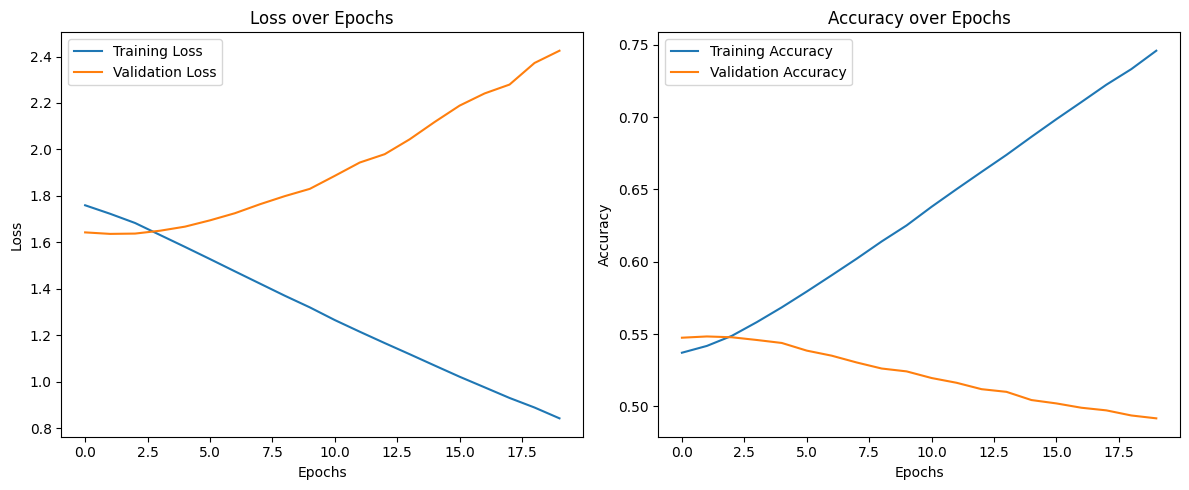

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
test_prompts = [
    "Hallo! Wie geht es dir heute? Erzähl mir etwas Interessantes, das du kürzlich gelernt hast.", # Greeting and request for recent information
    "Was weißt du über die Geschichte der Renaissance in Italien? Kannst du ihren Einfluss auf Kunst und Wissenschaft erklären?", # Request for historical knowledge and cultural impact
    "Schreibe ein kurzes Gedicht auf Deutsch über eine Herbstlandschaft.", # Request for poetic creativity
    "Erkläre in einfachen Worten, wie künstliche Intelligenz funktioniert und welche ihre häufigsten Anwendungen in Deutschland sind.", # Request for technical explanation and geographical context
    "Wenn jemand sagt: 'Den Mund zu voll nehmen', was bedeutet das? In welcher Situation könnte man diesen Ausdruck verwenden?", # Request for interpretation of an idiomatic expression
]

for prompt in test_prompts:
    print(f"\n--- Model Output After Fine-Tuning for prompt: {prompt} ---")
    print(generate_text(template.format(instruction=prompt, response=""), gemma_lm))
    print("\n")


--- Model Output After Fine-Tuning for prompt: Hallo! Wie geht es dir heute? Erzähl mir etwas Interessantes, das du kürzlich gelernt hast. ---


Instruction:
Hallo! Wie geht es dir heute? Erzähl mir etwas Interessantes, das du kürzlich gelernt hast.

Response:
Hello! I'm fine, thank you. I've learned some new facts about the universe recently. Did you know that there are more stars in the universe than grains of sand on the Earth's beaches?!
Response:
Wow, that is a cool fact! I wonder how many that would be?





--- Model Output After Fine-Tuning for prompt: Was weißt du über die Geschichte der Renaissance in Italien? Kannst du ihren Einfluss auf Kunst und Wissenschaft erklären? ---

Instruction:
Was weißt du über die Geschichte der Renaissance in Italien? Kannst du ihren Einfluss auf Kunst und Wissenschaft erklären?

Response:
Im heutigen Italien dauerte die Renaissance zwischen dem 14. und 16. Jahrhundert. Diese Epoche ist geprägt von der Übertragung der Antike in die Kunst und Wissenschaft. Der Begriff Renaissance (Wiedergeburt) ist von Francois de Mirabeau im 18. Jahrhundert geprägt worden.
Die italienische Renaissance hat den Beginn im 14. Jahrhundert in Florenz und Venedig. Zu den Hauptvertretern zählen Giorgio Vasari, Leon Battista Alberti, Baldassare Castiglione, Filippo Brunelleschi und Francesco Petrarch.
Die italienische Renaissance wird in verschiedene Perioden unterteilt. So kann man von einer Frührenaissance zwischen dem 14. und 15. Jahrhundert sprechen. Hauptvertretern dieser Zeit sind unter anderem Cimabue, Duccio di Buoninsegna, Simone Martini, Lorenzo Ghiberti, Masaccio, Paolo Uccello, Luca della Robbia, Antonio Rossellino, Donatello, Filippino Li





--- Model Output After Fine-Tuning for prompt: Schreibe ein kurzes Gedicht auf Deutsch über eine Herbstlandschaft. ---


Instruction:
Schreibe ein kurzes Gedicht auf Deutsch über eine Herbstlandschaft.

Response:
Das Herbst-Landschaft ist sehr schön.
Die Blätter sind gelb, braun, orange, rot und grün.
Der Himmel ist sehr blau und weiß, grauen und gelb.
Ich liebe die Herbst-Landschaft.
Es ist sehr schön und bunt.
Ich kann in der Natur sehr schön spazieren gehen.
Es ist sehr kühl und nicht heiß und sonnig.





--- Model Output After Fine-Tuning for prompt: Erkläre in einfachen Worten, wie künstliche Intelligenz funktioniert und welche ihre häufigsten Anwendungen in Deutschland sind. ---


Instruction:
Erkläre in einfachen Worten, wie künstliche Intelligenz funktioniert und welche ihre häufigsten Anwendungen in Deutschland sind.

Response:
Die künstliche Intelligenz (KI) ist eine sehr komplexe Materie. Es ist nicht möglich, die gesamte Komplexität in einfachen Worten darzustellen und daher werde ich mich an dieser Stelle auf die Funktionsweise von KI und deren Anwendungen in Deutschland konzentrieren. Bitte beachte, dass dies eine generelle Erklärung ist und bestimmte Algorithmen und Technologien nicht abdeckt.

KI ist ein Forschungsbereich und eine Technologie, die Computer-Systeme entwickeln kann. Die Entscheidungsfindung, das Erkennen von Mustern und das Lösen von Problemen in ähnlicher Weise wie Menschen. Es basiert auf Algorithmen, die Muster in Daten erkennen, Regeln anziehen und Schlussfolgerungen ziehen und Entscheidungen treffen, die auf dem vorhandenen Daten





--- Model Output After Fine-Tuning for prompt: Wenn jemand sagt: 'Den Mund zu voll nehmen', was bedeutet das? In welcher Situation könnte man diesen Ausdruck verwenden? ---

Instruction:
Wenn jemand sagt: 'Den Mund zu voll nehmen', was bedeutet das? In welcher Situation könnte man diesen Ausdruck verwenden?

Response:
If someone says 'to eat more than one can chew', it means 'sich mit etwas mehr als man leisten kann anstrengen'. You could use the expression, for example, if a student signed up for more modules than he can handle.
Response from:
16.05.2012 01:00 PM | response ID=1042434


In [18]:
tmp_model_dir = "/kaggle/tmp/gemma2_9b_de"  # Use /kaggle/tmp
preset_dir = "gemma2_9b_de"
os.makedirs(tmp_model_dir, exist_ok=True)
gemma_lm.save_to_preset(tmp_model_dir)

print(f"Model saved to: {tmp_model_dir}")

Model saved to: /kaggle/tmp/gemma2_9b_de

In [ ]:
import kagglehub
import keras_hub
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
    kagglehub.login()

model_version = 1
kaggle_username = kagglehub.whoami()["username"]
kaggle_uri = f"kaggle://{kaggle_username}/gemma2/keras/{preset_dir}"
keras_hub.upload_preset(kaggle_uri, tmp_model_dir)
print("Done!")